<a href="https://colab.research.google.com/github/usamaali1998/casestudy/blob/main/case_study_plm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

📌 1. Introduction

Objective:
Forecast daily total order demand for a logistics operation using time-series models and compare simple, main, and benchmark models.

Models used:

Seasonal Naive (Baseline)

ETS – Exponential Smoothing (Main Model)

Auto-ARIMA (Benchmark Model)

📌 2. Install & Import Required Libraries

In [1]:
# Install required package (Colab)
!pip -q install pmdarima

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.metrics import mean_absolute_error, mean_squared_error
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import statsmodels.api as sm
import pmdarima as pm


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 689.1/689.1 kB 11.2 MB/s eta 0:00:00


📌 3. Load the Corrected Dataset

In [2]:
# Upload Daily_Demand_TS_CORRECTED.csv in Colab
df = pd.read_csv("Daily_Demand_TS_CORRECTED.csv")

df["Corrected_Date"] = pd.to_datetime(df["Corrected_Date"])
df = df.sort_values("Corrected_Date").reset_index(drop=True)

df.head()


,...1,"Week of the month (first week, second, third, fourth or fifth week",Day of the week (Monday to Friday),Non-urgent order,Urgent order,Order type A,Order type B,Order type C,Fiscal sector orders,Orders from the traffic controller sector,Banking orders (1),Banking orders (2),Banking orders (3),Target (Total orders),Date,Corrected_Date
0,0,1,4,316.307,223.270,61.543,175.586,302.448,0.000,65556,44914,188411,14793,539.577,2020-01-01,2020-01-08
1,1,1,5,128.633,96.042,38.058,56.037,130.580,0.000,40419,21399,89461,7679,224.675,2020-01-02,2020-01-09
2,2,1,6,43.651,84.375,21.826,25.125,82.461,1.386,11992,3452,21305,14947,129.412,2020-01-03,2020-01-10
3,3,2,2,171.297,127.667,41.542,113.294,162.284,18.156,49971,33703,69054,18423,317.120,2020-01-04,2020-01-13
4,4,2,3,90.532,113.526,37.679,56.618,116.220,6.459,48534,19646,16411,20257,210.517,2020-01-05,2020-01-14


📌 4. Define Target Variable

In [3]:
target_col = "Target (Total orders)"
df_ts = df.set_index("Corrected_Date")
y = df_ts[target_col]


📌 5. Time Series Visualization

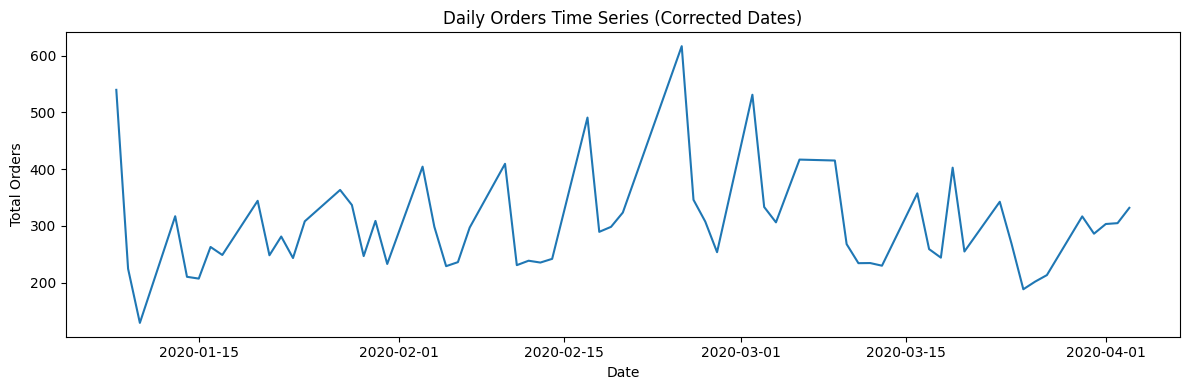

In [4]:
plt.figure(figsize=(12,4))
plt.plot(df_ts.index, y)
plt.title("Daily Orders Time Series (Corrected Dates)")
plt.xlabel("Date")
plt.ylabel("Total Orders")
plt.tight_layout()
plt.show()


📌 6. Train–Test Split (80/20)

In [5]:
n = len(df_ts)
train_size = int(0.8 * n)

train = y.iloc[:train_size]
test  = y.iloc[train_size:]

train_index = train.index
test_index  = test.index

season_length = 5  # business-day seasonality


📌 7. Evaluation Metrics

In [6]:
def mape(y_true, y_pred):
    eps = 1e-9
    return np.mean(np.abs((y_true - y_pred) / np.maximum(np.abs(y_true), eps))) * 100

def print_metrics(name, y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mp = mape(y_true, y_pred)
    print(f"\n{name}")
    print(f"MAE  = {mae:.4f}")
    print(f"RMSE = {rmse:.4f}")
    print(f"MAPE = {mp:.2f}%")


📌 8. Model 1 – Seasonal Naive (Baseline)

In [7]:
full_series = pd.concat([train, test])
snaive_pred = []

for i in range(train_size, n):
    snaive_pred.append(full_series.iloc[i - season_length])

snaive_pred = np.array(snaive_pred)

print_metrics("Seasonal Naive (Baseline)", test.values, snaive_pred)



Seasonal Naive (Baseline)
MAE  = 74.5439
RMSE = 97.0189
MAPE = 27.43%


📌 9. Model 2 – ETS (Exponential Smoothing)

In [8]:
ets_model = ExponentialSmoothing(
    train,
    trend="add",
    seasonal="add",
    seasonal_periods=season_length
).fit()

ets_forecast = ets_model.forecast(len(test))
print_metrics("ETS (Main Model)", test.values, ets_forecast.values)


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)



ETS (Main Model)
MAE  = 61.8036
RMSE = 82.1832
MAPE = 26.72%


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


📊 ETS Forecast Plot

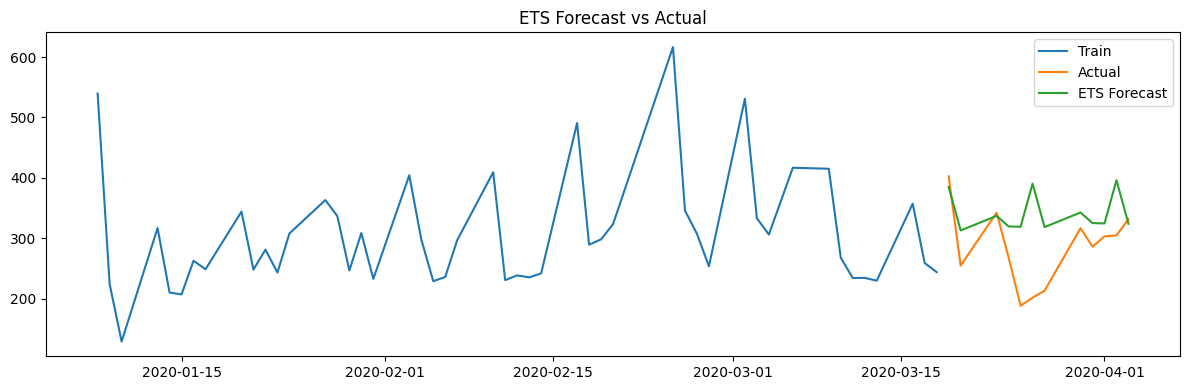

In [9]:
plt.figure(figsize=(12,4))
plt.plot(train_index, train, label="Train")
plt.plot(test_index, test, label="Actual")
plt.plot(test_index, ets_forecast, label="ETS Forecast")
plt.title("ETS Forecast vs Actual")
plt.legend()
plt.tight_layout()
plt.show()


📌 10. Model 3 – Auto-ARIMA (Benchmark)

In [10]:
arima_model = pm.auto_arima(
    train,
    seasonal=True,
    m=season_length,
    stepwise=True,
    suppress_warnings=True
)

arima_forecast = arima_model.predict(n_periods=len(test))
print_metrics("Auto-ARIMA (Benchmark)", test.values, arima_forecast)



Auto-ARIMA (Benchmark)
MAE  = 49.2537
RMSE = 63.5416
MAPE = 20.21%


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


📌 11. Decomposition (Trend, Seasonality, Residuals)

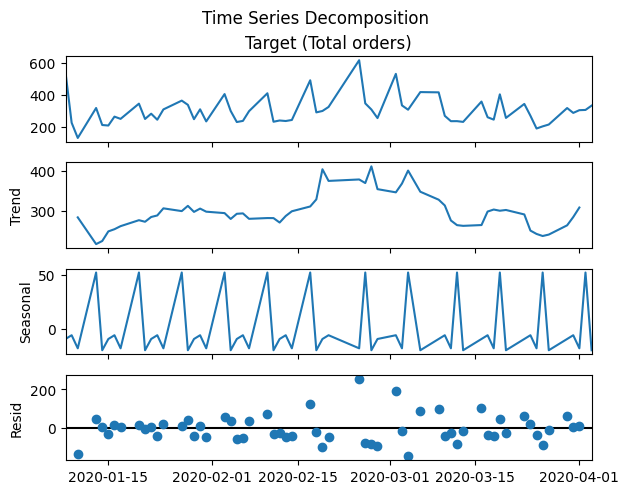

In [11]:
decomp = seasonal_decompose(y, model="additive", period=season_length)
decomp.plot()
plt.suptitle("Time Series Decomposition", y=1.02)
plt.show()


📌 12. ACF & PACF Analysis

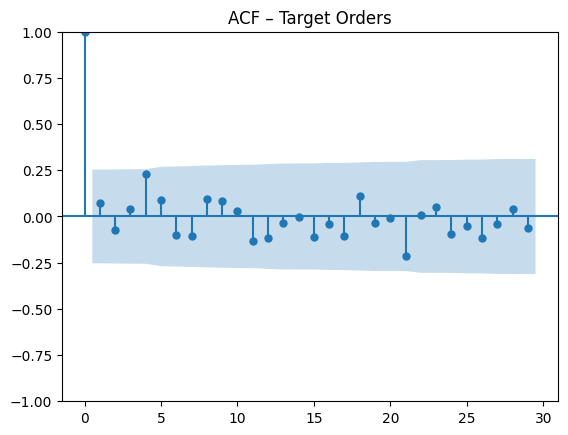

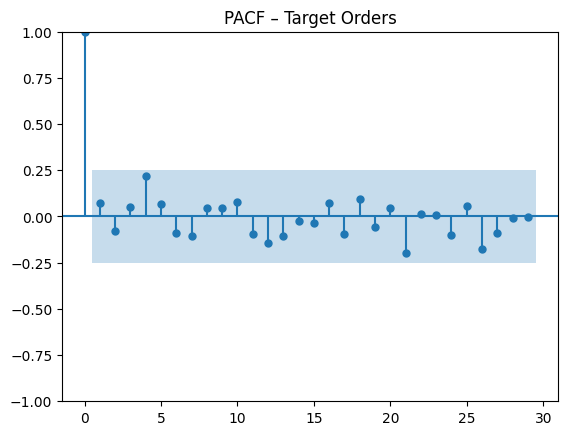

In [15]:
plot_acf(y, lags=29)
plt.title("ACF – Target Orders")
plt.show()

plot_pacf(y, lags=29, method="ywm")
plt.title("PACF – Target Orders")
plt.show()


📌 13. Distribution & Weekday Analysis

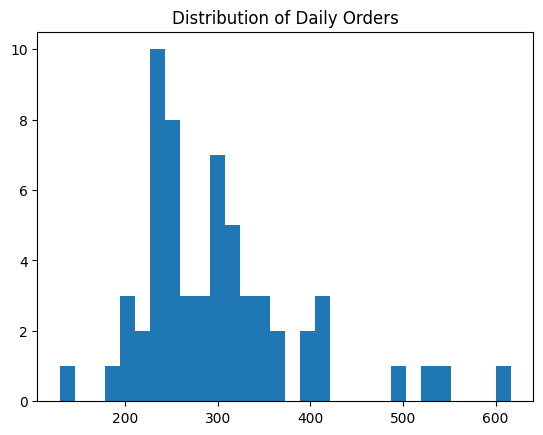

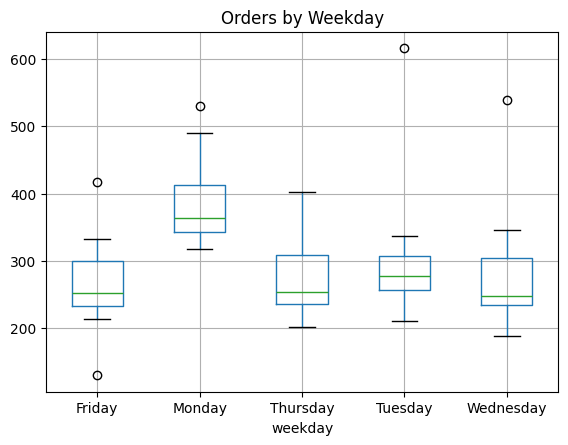

In [16]:
plt.hist(y, bins=30)
plt.title("Distribution of Daily Orders")
plt.show()

df_ts["weekday"] = df_ts.index.day_name()
df_ts.boxplot(column=target_col, by="weekday")
plt.title("Orders by Weekday")
plt.suptitle("")
plt.show()


📌 14. Rolling Mean Analysis

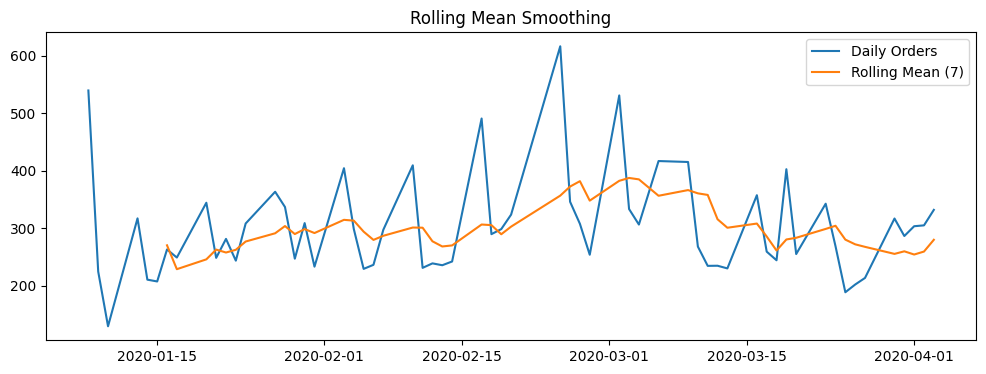

In [17]:
df_ts["rolling_7"] = y.rolling(7).mean()

plt.figure(figsize=(12,4))
plt.plot(y, label="Daily Orders")
plt.plot(df_ts["rolling_7"], label="Rolling Mean (7)")
plt.legend()
plt.title("Rolling Mean Smoothing")
plt.show()


📌 15. Forecast Comparison

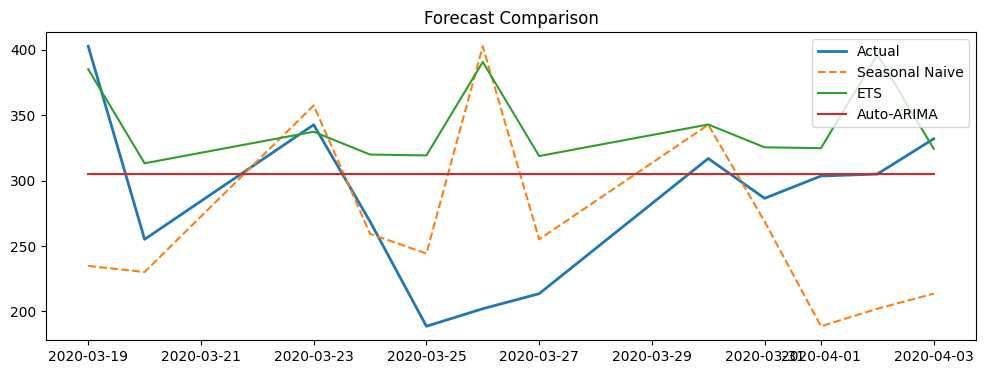

In [18]:
plt.figure(figsize=(12,4))
plt.plot(test_index, test, label="Actual", linewidth=2)
plt.plot(test_index, snaive_pred, label="Seasonal Naive", linestyle="--")
plt.plot(test_index, ets_forecast, label="ETS")
plt.plot(test_index, arima_forecast, label="Auto-ARIMA")
plt.legend()
plt.title("Forecast Comparison")
plt.show()


📌 16. Residual Diagnostics (ETS)

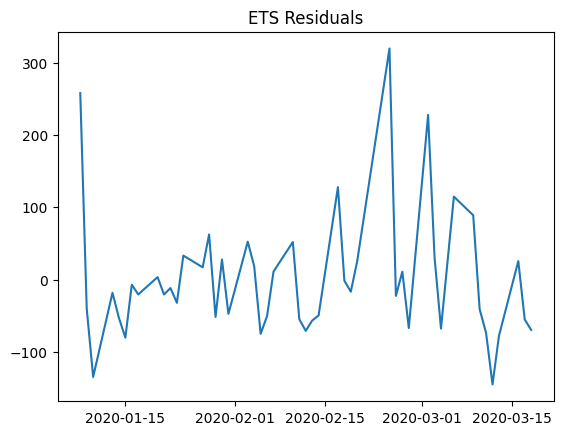

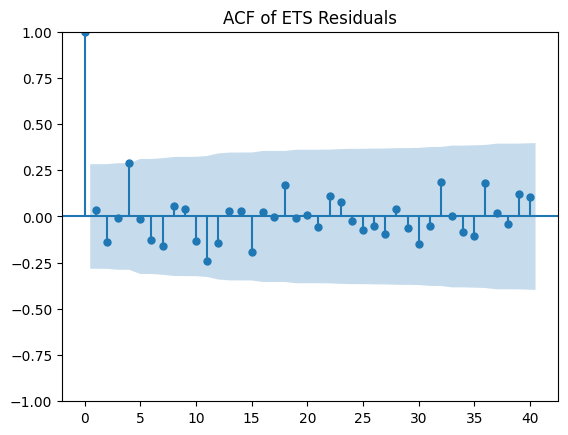

,lb_stat,lb_pvalue
10,9.51341,0.484168


In [19]:
ets_resid = ets_model.resid

plt.plot(ets_resid)
plt.title("ETS Residuals")
plt.show()

plot_acf(ets_resid.dropna(), lags=40)
plt.title("ACF of ETS Residuals")
plt.show()

sm.stats.acorr_ljungbox(ets_resid.dropna(), lags=[10], return_df=True)
